In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import utils.display as display
import numpy as np
import matplotlib.pyplot as plt
import torch 
from utils.signature import lead_matrix

%load_ext autoreload
%autoreload 2

log_path = "../log_dir/trained_models/main_model/"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

C:\Users\arthu\Desktop\PHD\projects\trial-matching\utils\logger.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=training_opt.device

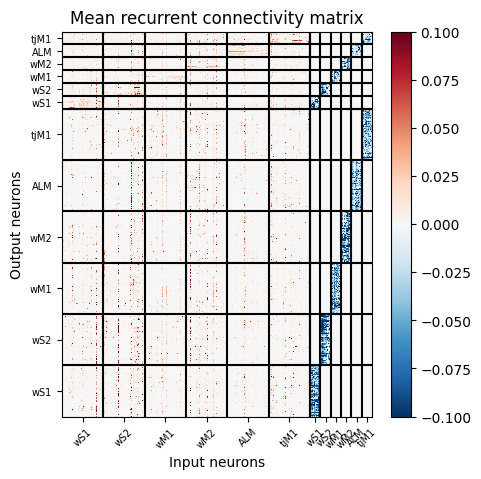

In [2]:
# Plot the mean recurrent connectivity matrix 
w_rec = model.rsnn._w_rec.detach().mean(0)
# Here all weights are positive, because the sign is calculated when we compute the currents.
#   That's why we multiply by -1 to have inhibitory weights in blue.
sign_mask = torch.ones(w_rec.shape)
sign_mask[:, -model.rsnn.inhibitory:] = -1 
w_rec = w_rec * sign_mask

w_rec = w_rec.numpy()
plt.figure(figsize=(5, 5))
plt.pcolormesh(w_rec, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Mean recurrent connectivity matrix")
plt.xlabel("Input neurons")
plt.ylabel("Output neurons")
# lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
for i in range(200, 1400, 200):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
for i in range(1200, 1500, 50):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
# put the name of areas as a x label on the plot {wS1, wS2, wM1, wM2, ALM, tjM1}
xticks = [100, 300, 500, 700, 900, 1100, 1225, 1275, 1325, 1375, 1425, 1475]
xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
plt.yticks(xticks, xlabels, fontsize=7)
plt.savefig("weights.png", dpi=300, bbox_inches="tight")

In [3]:
model.rsnn._w_rec.detach().shape

torch.Size([2, 1500, 1500])

In [38]:
w_rec_unsigned = model.rsnn._w_rec.detach()

num_areas = 6
pop_avg_w_rec = torch.zeros((2, 2*num_areas, 2*num_areas))
pop_max_w_rec = torch.zeros((2, 2*num_areas, 2*num_areas))

for in_exc in [True, False]:
    in_mask_exc = model.rsnn.excitatory_index == in_exc
    for in_id_area, in_area in enumerate(["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"]):
        in_mask_area = model.rsnn.area_index == in_id_area
        in_mask = in_mask_area & in_mask_exc
        in_id = (0 if in_exc else num_areas) + in_id_area
        
        for out_exc in [True, False]:
            out_mask_exc = model.rsnn.excitatory_index == out_exc
            for out_id_area, out_area in enumerate(["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"]):
                out_mask_area = model.rsnn.area_index == out_id_area
                out_mask = out_mask_area & out_mask_exc
                out_id = (0 if out_exc else num_areas) + out_id_area
                
                pop_avg_w_rec[:, out_id, in_id] = w_rec_unsigned[:, out_mask, :][:, :, in_mask].mean((1, 2))
                for k in range(2): pop_max_w_rec[k, out_id, in_id] = w_rec_unsigned[k][out_mask, :][:, in_mask].max()

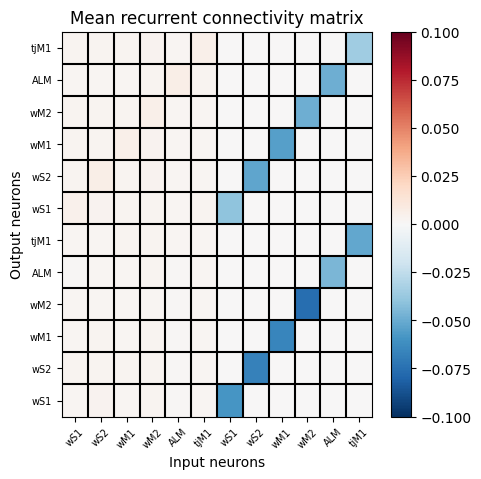

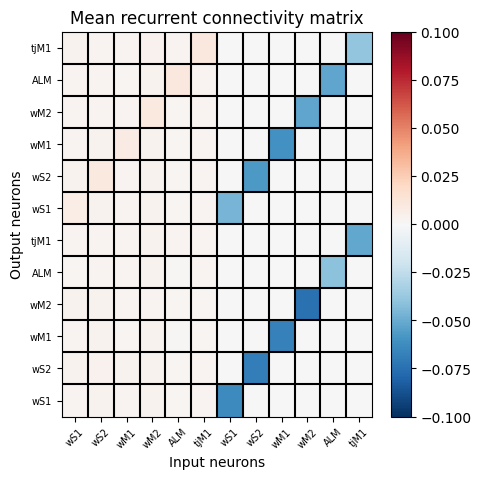

In [40]:
for k in range(2):
    weights = pop_avg_w_rec[k].numpy().copy()
    weights[:, num_areas:] = -weights[:, num_areas:]
    
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(weights, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
    plt.colorbar()
    plt.title("Mean recurrent connectivity matrix")
    plt.xlabel("Input neurons")
    plt.ylabel("Output neurons")
    # lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
    for i in range(1, 2*num_areas):
        plt.axvline(i, color="k")
        plt.axhline(i, color="k")
    xticks = np.arange(2*num_areas) + 0.5
    xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
    plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
    plt.yticks(xticks, xlabels, fontsize=7)

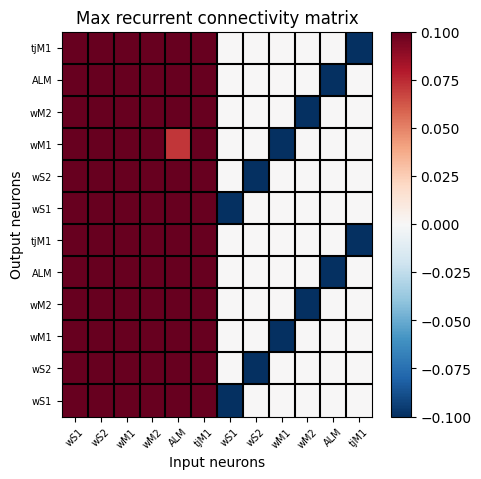

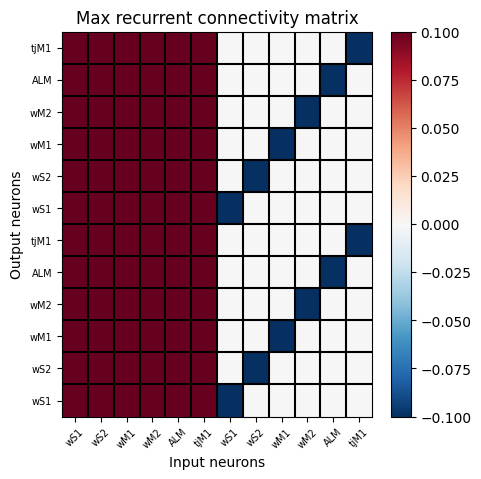

In [41]:
for k in range(2):
    weights = pop_max_w_rec[k].numpy().copy()
    weights[:, num_areas:] = -weights[:, num_areas:]
    
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(weights, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
    plt.colorbar()
    plt.title("Max recurrent connectivity matrix")
    plt.xlabel("Input neurons")
    plt.ylabel("Output neurons")
    # lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
    for i in range(1, 2*num_areas):
        plt.axvline(i, color="k")
        plt.axhline(i, color="k")
    xticks = np.arange(2*num_areas) + 0.5
    xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
    plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
    plt.yticks(xticks, xlabels, fontsize=7)

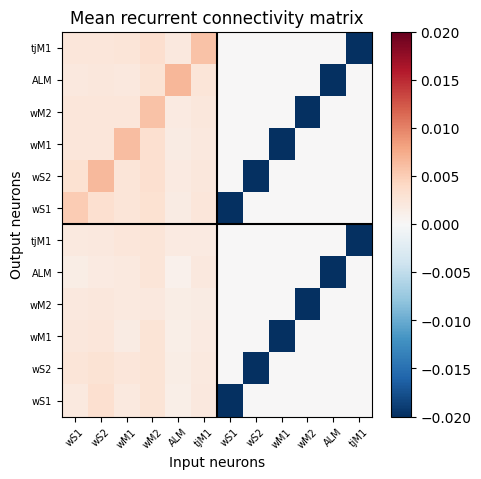

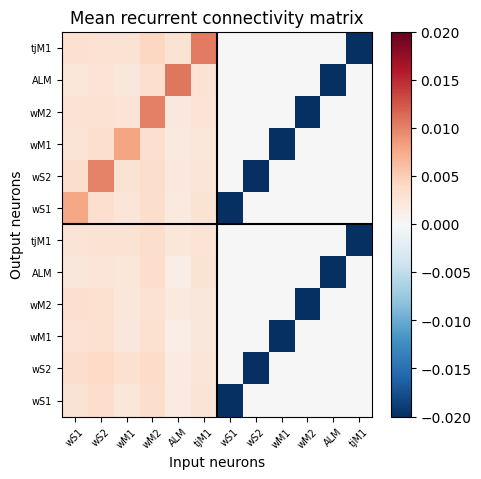

In [50]:
for k in range(2):
    weights = pop_avg_w_rec[k].numpy().copy()
    weights[:, num_areas:] = -weights[:, num_areas:]
    
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(weights, cmap="RdBu_r", vmin=-0.02, vmax=0.02)
    plt.colorbar()
    plt.title("Mean recurrent connectivity matrix")
    plt.xlabel("Input neurons")
    plt.ylabel("Output neurons")
    plt.axvline(num_areas, color="k")
    plt.axhline(num_areas, color="k")
    xticks = np.arange(2*num_areas) + 0.5
    xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
    plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
    plt.yticks(xticks, xlabels, fontsize=7)

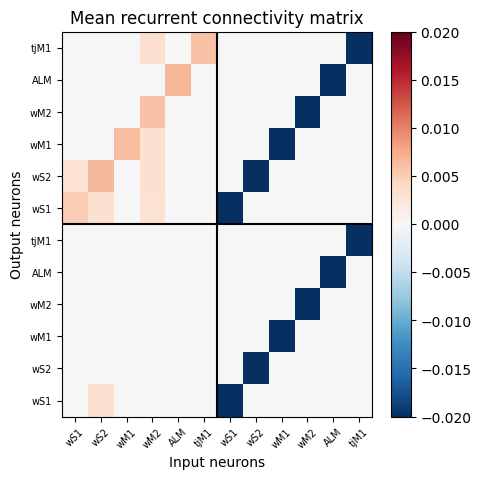

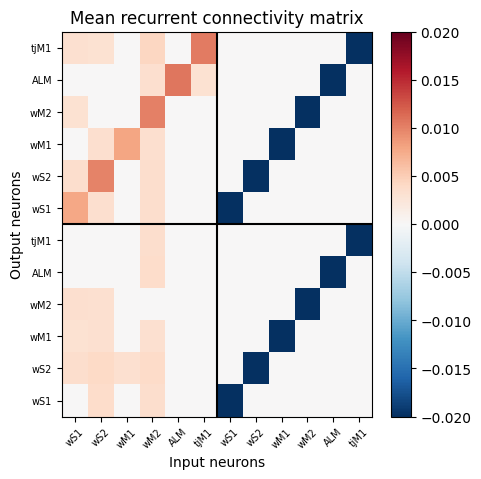

In [55]:
for k in range(2):
    threshold = 0.003
    weights = pop_avg_w_rec[k].numpy().copy()
    weights[weights < threshold] = 0
    weights[:, num_areas:] = -weights[:, num_areas:]
    
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(weights, cmap="RdBu_r", vmin=-0.02, vmax=0.02)
    plt.colorbar()
    plt.title("Mean recurrent connectivity matrix")
    plt.xlabel("Input neurons")
    plt.ylabel("Output neurons")
    plt.axvline(num_areas, color="k")
    plt.axhline(num_areas, color="k")
    xticks = np.arange(2*num_areas) + 0.5
    xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
    plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
    plt.yticks(xticks, xlabels, fontsize=7)

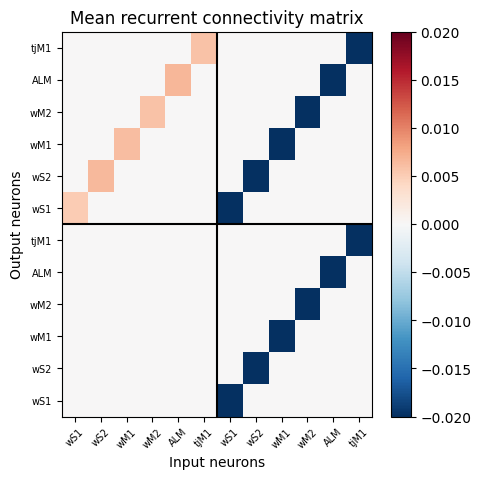

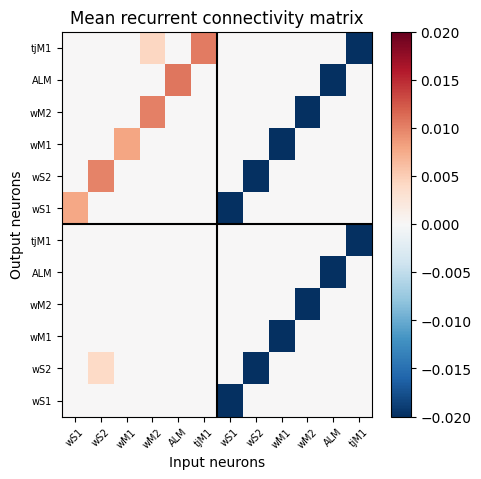

In [57]:
for k in range(2):
    threshold = 0.004
    weights = pop_avg_w_rec[k].numpy().copy()
    weights[weights < threshold] = 0
    weights[:, num_areas:] = -weights[:, num_areas:]
    
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(weights, cmap="RdBu_r", vmin=-0.02, vmax=0.02)
    plt.colorbar()
    plt.title("Mean recurrent connectivity matrix")
    plt.xlabel("Input neurons")
    plt.ylabel("Output neurons")
    plt.axvline(num_areas, color="k")
    plt.axhline(num_areas, color="k")
    xticks = np.arange(2*num_areas) + 0.5
    xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
    plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
    plt.yticks(xticks, xlabels, fontsize=7)

In [60]:
model.rsnn._w_jaw_post.shape

torch.Size([14, 1500])

In [62]:
model.rsnn._w_jaw_pre.shape

torch.Size([400, 1])

In [64]:
model.rsnn._w_in.shape

torch.Size([1500, 300])

([<matplotlib.axis.YTick at 0x19e8978b8f0>], [Text(0, 0.5, 'jaw')])

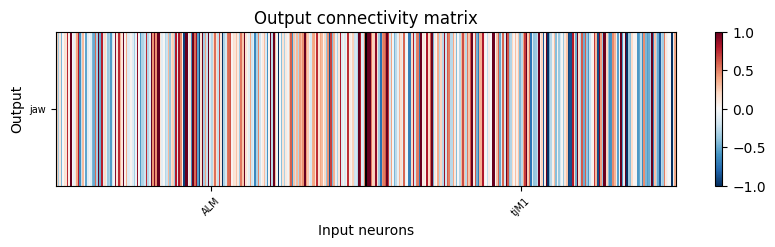

In [76]:
w = model.rsnn._w_jaw_pre.detach()
w = w.numpy()

plt.figure(figsize=(10, 2))
plt.pcolormesh(w.T, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Output connectivity matrix")
plt.xlabel("Input neurons")
plt.ylabel("Output")
# lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
for i in range(0, 400, 200):
    plt.axvline(i, color="k")
# put the name of areas as a x label on the plot {wS1, wS2, wM1, wM2, ALM, tjM1}
xticks = [100, 300]
xlabels = ["ALM", "tjM1"]
yticks =  [0.5]
ylabels = ["jaw"]
plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
plt.yticks(yticks, ylabels, fontsize=7)

([<matplotlib.axis.YTick at 0x19e87477fe0>,
 [Text(0, 100, 'wS1'),
  Text(0, 300, 'wS2'),
  Text(0, 500, 'wM1'),
  Text(0, 700, 'wM2'),
  Text(0, 900, 'ALM'),
  Text(0, 1100, 'tjM1'),
  Text(0, 1225, 'wS1'),
  Text(0, 1275, 'wS2'),
  Text(0, 1325, 'wM1'),
  Text(0, 1375, 'wM2'),
  Text(0, 1425, 'ALM'),
  Text(0, 1475, 'tjM1')])

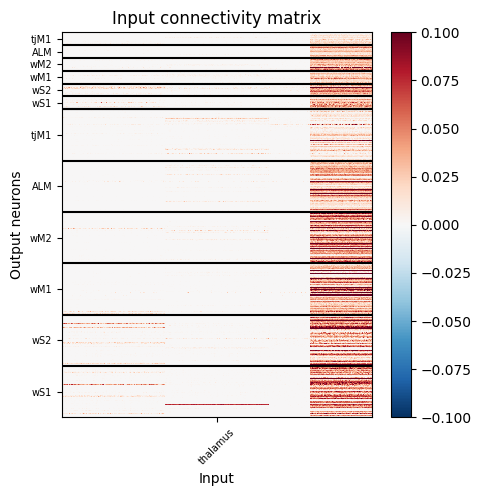

In [79]:
w = model.rsnn._w_in.detach()
w = w.numpy()

plt.figure(figsize=(5, 5))
plt.pcolormesh(w, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Input connectivity matrix")
plt.xlabel("Input")
plt.ylabel("Output neurons")
# lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
for i in range(200, 1400, 200):
    plt.axhline(i, color="k")
for i in range(1200, 1500, 50):
    plt.axhline(i, color="k")
# put the name of areas as a x label on the plot {wS1, wS2, wM1, wM2, ALM, tjM1}
xticks = [150]
xlabels = ["thalamus"]
yticks = [100, 300, 500, 700, 900, 1100, 1225, 1275, 1325, 1375, 1425, 1475]
ylabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
plt.yticks(yticks, ylabels, fontsize=7)